In [1]:
# to access functions from root directory
import sys
sys.path.append('/data/ad181/RemoteDir/ada_multigrid_ppo')

In [2]:
%matplotlib notebook
import numpy as np
import time
import pickle
import os
import matplotlib.pyplot as plt
from copy import copy, deepcopy

import gym
from stable_baselines3.ppo import PPO, MlpPolicy
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.callbacks import CallbackList
from utils.custom_eval_callback import CustomEvalCallback, CustomEvalCallbackParallel
from utils.env_wrappers import StateCoarse, BufferWrapper, EnvCoarseWrapper, StateCoarseMultiGrid
from typing import Callable
from utils.plot_functions import plot_learning
from utils.multigrid_framework_functions import env_wrappers_multigrid, make_env, generate_beta_environement, parallalize_env, multigrid_framework

from model.ressim import Grid
from ressim_env import ResSimEnv_v0, ResSimEnv_v1

/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/co

In [3]:
seed=1
case='case_1_singlegrid_one'
data_dir='./data'
log_dir='./data/'+case

In [4]:
os.makedirs(data_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

In [5]:
with open('../envs_params/env_data/env_train.pkl', 'rb') as input:
    env_train = pickle.load(input)

# define RL model and callbacks

In [6]:
def generate_model(env_train, seed):
    dummy_env =  generate_beta_environement(env_train, 0.5, env_train.p_x, env_train.p_y, seed)
    dummy_env_parallel = parallalize_env(dummy_env, num_actor=64, seed=seed)
    model = PPO(policy=MlpPolicy,
                env=dummy_env_parallel,
                learning_rate = 3e-6,
                n_steps = 40,
                batch_size = 16,
                n_epochs = 20,
                gamma = 0.99,
                gae_lambda = 0.95,
                clip_range = 0.1,
                clip_range_vf = None,
                ent_coef = 0.001,
                vf_coef = 0.5,
                max_grad_norm = 0.5,
                use_sde= False,
                create_eval_env= False,
                policy_kwargs = dict(net_arch=[150,100,80], log_std_init=-2.9),
                verbose = 1,
                target_kl = 0.05,
                seed = seed,
                device = "auto")
    return model

def generate_callback(env_train, best_model_save_path, log_path, eval_freq):
    dummy_env = generate_beta_environement(env_train, 0.5, env_train.p_x, env_train.p_y, seed)
    callback = CustomEvalCallbackParallel(dummy_env, 
                                          best_model_save_path=best_model_save_path, 
                                          n_eval_episodes=1,
                                          log_path=log_path, 
                                          eval_freq=eval_freq)
    return callback

# multigrid framework

/data/ad181/RemoteDir/ada_multigrid_ppo/utils/coarse_grid_functions.py:51: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for j in range(len(p_1)-1):


Using cuda device
seed 1: grid fidelity factor 1.0 learning ..
environement grid size (nx x ny ): 61 x 61


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f8de177c208> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f8d566bb978>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.60 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------
| eval/              |          |
|    mean_ep_length  | 5        |
|    mean_reward     | 0.599    |
| time/              |          |
|    fps             | 63       |
|    iterations      | 1        |
|    time_elapsed    | 40       |
|    total_timesteps | 2560     |
---------------------------------
policy iteration runtime: 70 seconds

Total episode rollouts: 512

Eval num_timesteps=2560, episode_reward=0.60 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.603       |
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 1           |
|    time_elapsed         | 26          |
|    total_timesteps      | 2560        |
| t

policy iteration runtime: 56 seconds

Total episode rollouts: 4608

Eval num_timesteps=2560, episode_reward=0.62 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.622       |
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 1           |
|    time_elapsed         | 26          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.011166987 |
|    clip_fraction        | 0.33        |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.736       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0735      |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.029      |
|    std                  | 

policy iteration runtime: 52 seconds

Total episode rollouts: 8704

Eval num_timesteps=2560, episode_reward=0.65 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.646       |
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 1           |
|    time_elapsed         | 26          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008172962 |
|    clip_fraction        | 0.336       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.784       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0755      |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.029      |
|    std                  | 

policy iteration runtime: 48 seconds

Total episode rollouts: 12800

Eval num_timesteps=2560, episode_reward=0.66 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.659       |
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 1           |
|    time_elapsed         | 26          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.007303393 |
|    clip_fraction        | 0.346       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.822       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0635      |
|    n_updates            | 500         |
|    policy_gradient_loss | -0.0302     |
|    std                  |

policy iteration runtime: 55 seconds

Total episode rollouts: 16896

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.668       |
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 1           |
|    time_elapsed         | 26          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008218849 |
|    clip_fraction        | 0.339       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.831       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0434      |
|    n_updates            | 660         |
|    policy_gradient_loss | -0.0308     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 51 seconds

Total episode rollouts: 20992

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.677        |
| time/                   |              |
|    fps                  | 97           |
|    iterations           | 1            |
|    time_elapsed         | 26           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0066726804 |
|    clip_fraction        | 0.338        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.84         |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0606       |
|    n_updates            | 820          |
|    policy_gradient_loss | -0.0298      |
|    std

policy iteration runtime: 52 seconds

Total episode rollouts: 25088

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.684       |
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 1           |
|    time_elapsed         | 26          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008118639 |
|    clip_fraction        | 0.353       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.851       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0439      |
|    n_updates            | 980         |
|    policy_gradient_loss | -0.0303     |
|    std                  |

policy iteration runtime: 47 seconds

Total episode rollouts: 29184

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.691       |
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 1           |
|    time_elapsed         | 26          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.005781689 |
|    clip_fraction        | 0.369       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.854       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0412      |
|    n_updates            | 1140        |
|    policy_gradient_loss | -0.0322     |
|    std                  |

policy iteration runtime: 48 seconds

Total episode rollouts: 33280

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.694       |
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 1           |
|    time_elapsed         | 26          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.007271701 |
|    clip_fraction        | 0.358       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.862       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0703      |
|    n_updates            | 1300        |
|    policy_gradient_loss | -0.0309     |
|    std                  |

policy iteration runtime: 52 seconds

Total episode rollouts: 37376

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.694       |
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 1           |
|    time_elapsed         | 26          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.004671505 |
|    clip_fraction        | 0.353       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.871       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0379      |
|    n_updates            | 1460        |
|    policy_gradient_loss | -0.0297     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 55 seconds

Total episode rollouts: 41472

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.694        |
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 1            |
|    time_elapsed         | 26           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0068011046 |
|    clip_fraction        | 0.351        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.87         |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0787       |
|    n_updates            | 1620         |
|    policy_gradient_loss | -0.0301      |
|    std                  | 0.

policy iteration runtime: 53 seconds

Total episode rollouts: 45568

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.695       |
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 1           |
|    time_elapsed         | 26          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.010541022 |
|    clip_fraction        | 0.386       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.875       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0279      |
|    n_updates            | 1780        |
|    policy_gradient_loss | -0.034      |
|    std                  |

policy iteration runtime: 47 seconds

Total episode rollouts: 49664

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.695       |
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 1           |
|    time_elapsed         | 26          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.004108685 |
|    clip_fraction        | 0.395       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.865       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0451      |
|    n_updates            | 1940        |
|    policy_gradient_loss | -0.0325     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 47 seconds

Total episode rollouts: 53760

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.696       |
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 1           |
|    time_elapsed         | 26          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.010220888 |
|    clip_fraction        | 0.364       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.9        |
|    explained_variance   | 0.879       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.11        |
|    n_updates            | 2100        |
|    policy_gradient_loss | -0.0317     |
|    std                  |

policy iteration runtime: 54 seconds

Total episode rollouts: 57856

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.697       |
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 1           |
|    time_elapsed         | 26          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008653412 |
|    clip_fraction        | 0.348       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.9        |
|    explained_variance   | 0.863       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0548      |
|    n_updates            | 2260        |
|    policy_gradient_loss | -0.0287     |
|    std                  |

policy iteration runtime: 53 seconds

Total episode rollouts: 61952

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.697        |
| time/                   |              |
|    fps                  | 99           |
|    iterations           | 1            |
|    time_elapsed         | 25           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0073593496 |
|    clip_fraction        | 0.373        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.9         |
|    explained_variance   | 0.877        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0635       |
|    n_updates            | 2420         |
|    policy_gradient_loss | -0.031       |
|    std                  | 0.

policy iteration runtime: 57 seconds

Total episode rollouts: 66048

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.697      |
| time/                   |            |
|    fps                  | 96         |
|    iterations           | 1          |
|    time_elapsed         | 26         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.00861902 |
|    clip_fraction        | 0.371      |
|    clip_range           | 0.1        |
|    entropy_loss         | 91.9       |
|    explained_variance   | 0.875      |
|    learning_rate        | 3e-06      |
|    loss                 | 0.078      |
|    n_updates            | 2580       |
|    policy_gradient_loss | -0.0312    |
|    std                  | 0.055      |
|    value_loss           |

policy iteration runtime: 54 seconds

Total episode rollouts: 70144

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.696       |
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 1           |
|    time_elapsed         | 26          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.006990093 |
|    clip_fraction        | 0.379       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.9        |
|    explained_variance   | 0.887       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0295      |
|    n_updates            | 2740        |
|    policy_gradient_loss | -0.0307     |
|    std                  | 0.0549      |
|    va

policy iteration runtime: 46 seconds

Total episode rollouts: 74240

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.695       |
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 1           |
|    time_elapsed         | 26          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.005207804 |
|    clip_fraction        | 0.371       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.9        |
|    explained_variance   | 0.881       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0618      |
|    n_updates            | 2900        |
|    policy_gradient_loss | -0.0308     |
|    std                  | 0.0549      |
|    va

<IPython.core.display.Javascript object>


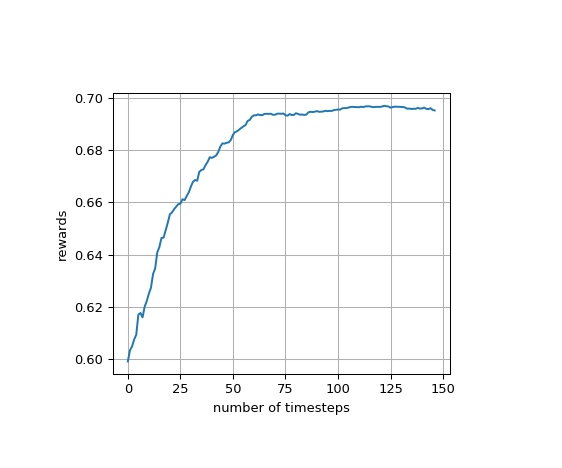

Using cuda device
seed 2: grid fidelity factor 1.0 learning ..
environement grid size (nx x ny ): 61 x 61


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f8d56428400> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f8d56392240>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.61 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.605       |
| time/                   |             |
|    fps                  | 59          |
|    iterations           | 1           |
|    time_elapsed         | 43          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.004231694 |
|    clip_fraction        | 0.383       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.9        |
|    explained_variance   | 0.881       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0671      |
|    n_updates            | 2940        |
|    policy_gradient_loss | -0.0302     |
|    std                  | 0.0549      |
|    value_loss           | 0.00407     |
------------

policy iteration runtime: 56 seconds

Total episode rollouts: 4096

Eval num_timesteps=2560, episode_reward=0.63 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.627       |
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 1           |
|    time_elapsed         | 26          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.013538072 |
|    clip_fraction        | 0.323       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.741       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0559      |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0276     |
|    std                  | 

policy iteration runtime: 54 seconds

Total episode rollouts: 8192

Eval num_timesteps=2560, episode_reward=0.65 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.647       |
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 1           |
|    time_elapsed         | 26          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.010535034 |
|    clip_fraction        | 0.345       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.786       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0735      |
|    n_updates            | 320         |
|    policy_gradient_loss | -0.0287     |
|    std                  | 

policy iteration runtime: 55 seconds

Total episode rollouts: 12288

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.669       |
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 1           |
|    time_elapsed         | 26          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008170026 |
|    clip_fraction        | 0.336       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.806       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0718      |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.0278     |
|    std                  |

policy iteration runtime: 56 seconds

Total episode rollouts: 16384

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.676       |
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 1           |
|    time_elapsed         | 26          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.004820061 |
|    clip_fraction        | 0.346       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.822       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0469      |
|    n_updates            | 640         |
|    policy_gradient_loss | -0.0299     |
|    std                  |

policy iteration runtime: 56 seconds

Total episode rollouts: 20480

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.684       |
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 1           |
|    time_elapsed         | 26          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.009477729 |
|    clip_fraction        | 0.349       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.842       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0479      |
|    n_updates            | 800         |
|    policy_gradient_loss | -0.0309     |
|    std                  |

policy iteration runtime: 58 seconds

Total episode rollouts: 24576

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.689        |
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 1            |
|    time_elapsed         | 26           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0064792456 |
|    clip_fraction        | 0.341        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.843        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0828       |
|    n_updates            | 960          |
|    policy_gradient_loss | -0.03        |
|    std

policy iteration runtime: 53 seconds

Total episode rollouts: 28672

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.694       |
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 1           |
|    time_elapsed         | 27          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.005904317 |
|    clip_fraction        | 0.346       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.842       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0365      |
|    n_updates            | 1120        |
|    policy_gradient_loss | -0.0299     |
|    std                  |

policy iteration runtime: 56 seconds

Total episode rollouts: 32768

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.695        |
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 1            |
|    time_elapsed         | 26           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0039875656 |
|    clip_fraction        | 0.357        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.858        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.057        |
|    n_updates            | 1280         |
|    policy_gradient_loss | -0.0303      |
|    std                  | 0.

policy iteration runtime: 59 seconds

Total episode rollouts: 36864

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.697       |
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 1           |
|    time_elapsed         | 26          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.004607162 |
|    clip_fraction        | 0.359       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.852       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.052       |
|    n_updates            | 1440        |
|    policy_gradient_loss | -0.0306     |
|    std                  |

policy iteration runtime: 57 seconds

Total episode rollouts: 40960

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.697       |
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 1           |
|    time_elapsed         | 26          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.005476949 |
|    clip_fraction        | 0.358       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.866       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0574      |
|    n_updates            | 1600        |
|    policy_gradient_loss | -0.0311     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 57 seconds

Total episode rollouts: 45056

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.698        |
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1            |
|    time_elapsed         | 27           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0061766803 |
|    clip_fraction        | 0.349        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.872        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0493       |
|    n_updates            | 1760         |
|    policy_gradient_loss | -0.0294      |
|    std

policy iteration runtime: 57 seconds

Total episode rollouts: 49152

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.699       |
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 1           |
|    time_elapsed         | 26          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008485216 |
|    clip_fraction        | 0.361       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.878       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0423      |
|    n_updates            | 1920        |
|    policy_gradient_loss | -0.0304     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 63 seconds

Total episode rollouts: 53248

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.699       |
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 1           |
|    time_elapsed         | 27          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008350646 |
|    clip_fraction        | 0.367       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.865       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0346      |
|    n_updates            | 2080        |
|    policy_gradient_loss | -0.0304     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 55 seconds

Total episode rollouts: 57856

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.699        |
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 1            |
|    time_elapsed         | 26           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0039416077 |
|    clip_fraction        | 0.359        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.873        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0763       |
|    n_updates            | 2260         |
|    policy_gradient_loss | -0.0292      |
|    std                  | 0.

policy iteration runtime: 60 seconds

Total episode rollouts: 61952

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.698       |
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 1           |
|    time_elapsed         | 26          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.006382674 |
|    clip_fraction        | 0.365       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.875       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0684      |
|    n_updates            | 2420        |
|    policy_gradient_loss | -0.03       |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 56 seconds

Total episode rollouts: 66048

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.698        |
| time/                   |              |
|    fps                  | 97           |
|    iterations           | 1            |
|    time_elapsed         | 26           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0054953517 |
|    clip_fraction        | 0.366        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.878        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.045        |
|    n_updates            | 2580         |
|    policy_gradient_loss | -0.0295      |
|    std                  | 0.

policy iteration runtime: 53 seconds

Total episode rollouts: 70144

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.697        |
| time/                   |              |
|    fps                  | 97           |
|    iterations           | 1            |
|    time_elapsed         | 26           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0062572137 |
|    clip_fraction        | 0.384        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.873        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0453       |
|    n_updates            | 2740         |
|    policy_gradient_loss | -0.0317      |
|    std                  | 0.

policy iteration runtime: 64 seconds

Total episode rollouts: 74240

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.698       |
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 1           |
|    time_elapsed         | 26          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.006911981 |
|    clip_fraction        | 0.367       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.876       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0465      |
|    n_updates            | 2900        |
|    policy_gradient_loss | -0.0311     |
|    std                  | 0.0551      |
|    va

<IPython.core.display.Javascript object>


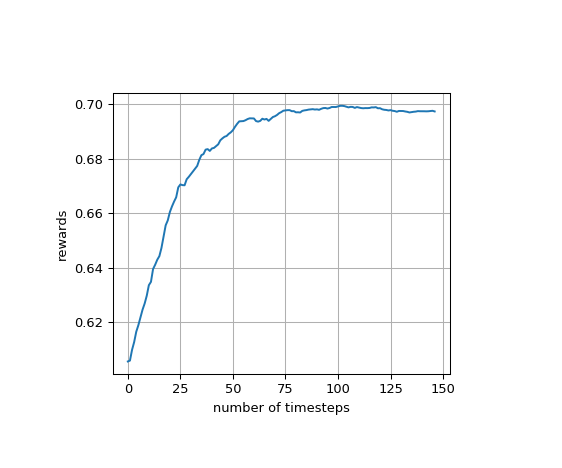

Using cuda device
seed 3: grid fidelity factor 1.0 learning ..
environement grid size (nx x ny ): 61 x 61


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f8d56896fd0> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f8d080cc080>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.60 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.603      |
| time/                   |            |
|    fps                  | 60         |
|    iterations           | 1          |
|    time_elapsed         | 42         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.00735421 |
|    clip_fraction        | 0.382      |
|    clip_range           | 0.1        |
|    entropy_loss         | 91.8       |
|    explained_variance   | 0.882      |
|    learning_rate        | 3e-06      |
|    loss                 | 0.0661     |
|    n_updates            | 2940       |
|    policy_gradient_loss | -0.0316    |
|    std                  | 0.0551     |
|    value_loss           | 0.0042     |
---------------------------------

policy iteration runtime: 54 seconds

Total episode rollouts: 4096

Eval num_timesteps=2560, episode_reward=0.62 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.618       |
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 1           |
|    time_elapsed         | 27          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.011021134 |
|    clip_fraction        | 0.335       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.711       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0519      |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0267     |
|    std                  | 

policy iteration runtime: 56 seconds

Total episode rollouts: 8192

Eval num_timesteps=2560, episode_reward=0.64 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.639        |
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 1            |
|    time_elapsed         | 26           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0068844557 |
|    clip_fraction        | 0.331        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.799        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0316       |
|    n_updates            | 320          |
|    policy_gradient_loss | -0.0267      |
|    std 

policy iteration runtime: 67 seconds

Total episode rollouts: 12288

Eval num_timesteps=2560, episode_reward=0.66 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.658      |
| time/                   |            |
|    fps                  | 95         |
|    iterations           | 1          |
|    time_elapsed         | 26         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.00940643 |
|    clip_fraction        | 0.337      |
|    clip_range           | 0.1        |
|    entropy_loss         | 91.7       |
|    explained_variance   | 0.823      |
|    learning_rate        | 3e-06      |
|    loss                 | 0.0835     |
|    n_updates            | 480        |
|    policy_gradient_loss | -0.0284    |
|    std                  | 0.0551     |
|    

policy iteration runtime: 56 seconds

Total episode rollouts: 16384

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.672        |
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1            |
|    time_elapsed         | 27           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0060836645 |
|    clip_fraction        | 0.338        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.7         |
|    explained_variance   | 0.832        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0752       |
|    n_updates            | 640          |
|    policy_gradient_loss | -0.0285      |
|    std

policy iteration runtime: 54 seconds

Total episode rollouts: 20480

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.681       |
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 1           |
|    time_elapsed         | 26          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.012138143 |
|    clip_fraction        | 0.367       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.7        |
|    explained_variance   | 0.856       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0624      |
|    n_updates            | 800         |
|    policy_gradient_loss | -0.0309     |
|    std                  |

policy iteration runtime: 57 seconds

Total episode rollouts: 24576

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.689      |
| time/                   |            |
|    fps                  | 93         |
|    iterations           | 1          |
|    time_elapsed         | 27         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.00682818 |
|    clip_fraction        | 0.345      |
|    clip_range           | 0.1        |
|    entropy_loss         | 91.7       |
|    explained_variance   | 0.853      |
|    learning_rate        | 3e-06      |
|    loss                 | 0.0465     |
|    n_updates            | 960        |
|    policy_gradient_loss | -0.0292    |
|    std                  | 0.0551     |
|    value_loss           |

policy iteration runtime: 53 seconds

Total episode rollouts: 28672

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.692       |
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 1           |
|    time_elapsed         | 26          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.005947006 |
|    clip_fraction        | 0.344       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.7        |
|    explained_variance   | 0.857       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0593      |
|    n_updates            | 1120        |
|    policy_gradient_loss | -0.0286     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 56 seconds

Total episode rollouts: 32768

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.693        |
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1            |
|    time_elapsed         | 27           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0039437087 |
|    clip_fraction        | 0.344        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.7         |
|    explained_variance   | 0.864        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0755       |
|    n_updates            | 1280         |
|    policy_gradient_loss | -0.0297      |
|    std

policy iteration runtime: 56 seconds

Total episode rollouts: 36864

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.695        |
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 1            |
|    time_elapsed         | 26           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0030025751 |
|    clip_fraction        | 0.355        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.7         |
|    explained_variance   | 0.869        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0581       |
|    n_updates            | 1440         |
|    policy_gradient_loss | -0.0299      |
|    std

policy iteration runtime: 60 seconds

Total episode rollouts: 40960

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.694       |
| time/                   |             |
|    fps                  | 92          |
|    iterations           | 1           |
|    time_elapsed         | 27          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008034607 |
|    clip_fraction        | 0.338       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.7        |
|    explained_variance   | 0.862       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0712      |
|    n_updates            | 1600        |
|    policy_gradient_loss | -0.0289     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 65 seconds

Total episode rollouts: 45056

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.696        |
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 1            |
|    time_elapsed         | 26           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0041481047 |
|    clip_fraction        | 0.361        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.7         |
|    explained_variance   | 0.871        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0599       |
|    n_updates            | 1760         |
|    policy_gradient_loss | -0.0304      |
|    std                  | 0.

policy iteration runtime: 57 seconds

Total episode rollouts: 49152

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.697       |
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 1           |
|    time_elapsed         | 26          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008227495 |
|    clip_fraction        | 0.365       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.873       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0727      |
|    n_updates            | 1920        |
|    policy_gradient_loss | -0.0301     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 54 seconds

Total episode rollouts: 53248

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.698        |
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 1            |
|    time_elapsed         | 26           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0030363277 |
|    clip_fraction        | 0.367        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.888        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0454       |
|    n_updates            | 2080         |
|    policy_gradient_loss | -0.0307      |
|    std

policy iteration runtime: 55 seconds

Total episode rollouts: 57344

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.699        |
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1            |
|    time_elapsed         | 27           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0076729446 |
|    clip_fraction        | 0.357        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.882        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.063        |
|    n_updates            | 2240         |
|    policy_gradient_loss | -0.0294      |
|    std

policy iteration runtime: 56 seconds

Total episode rollouts: 61440

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.698       |
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 1           |
|    time_elapsed         | 26          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.005091116 |
|    clip_fraction        | 0.355       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.882       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0365      |
|    n_updates            | 2400        |
|    policy_gradient_loss | -0.0288     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 46 seconds

Total episode rollouts: 65536

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.699        |
| time/                   |              |
|    fps                  | 92           |
|    iterations           | 1            |
|    time_elapsed         | 27           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0051849694 |
|    clip_fraction        | 0.371        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.889        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0507       |
|    n_updates            | 2560         |
|    policy_gradient_loss | -0.0298      |
|    std                  | 0.

policy iteration runtime: 61 seconds

Total episode rollouts: 69632

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.699        |
| time/                   |              |
|    fps                  | 66           |
|    iterations           | 1            |
|    time_elapsed         | 38           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0055318684 |
|    clip_fraction        | 0.36         |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.898        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0465       |
|    n_updates            | 2720         |
|    policy_gradient_loss | -0.0291      |
|    std                  | 0.

policy iteration runtime: 67 seconds

Total episode rollouts: 73728

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.699        |
| time/                   |              |
|    fps                  | 65           |
|    iterations           | 1            |
|    time_elapsed         | 39           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0066909045 |
|    clip_fraction        | 0.371        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.888        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0742       |
|    n_updates            | 2880         |
|    policy_gradient_loss | -0.0298      |
|    std                  | 0.

<IPython.core.display.Javascript object>


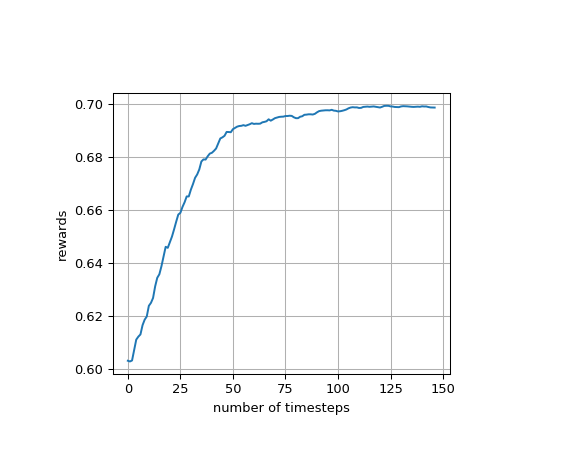

In [7]:
for seed in range(1,4):
    model = multigrid_framework(env_train, 
                                generate_model,
                                generate_callback, 
                                delta_pcent=0.2, 
                                n=np.inf,
                                grid_fidelity_factor_array =[1.0],
                                episode_limit_array=[75000], 
                                log_dir=log_dir,
                                seed=seed)